# Imports de base

In [ ]:
# --- 0. Environment Initialization ---
import os, math, warnings
from pathlib import Path

# Standard scientific libraries (Computation, DataFrames, Visualization)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Scikit-Learn modules: Preprocessing, Validation Strategy, and Models
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

# Global configuration: Suppress non-blocking warnings and set plot format
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (10,6)

# Definition of the root path and automatic listing of CSV data files
BASE = Path(".")
csv_files = sorted(p.name for p in BASE.glob("*.csv"))
csv_files

['IMU_10Hz.csv',
 'IMU_20Hz_freq_drop.csv',
 'IMU_20Hz_freq_drop_2.csv',
 'IMU_2Hz.csv',
 'IMU_Acc_Gyro_20Hz.csv',
 'IMU_earthquake.csv',
 'IMU_extra_weigth.csv',
 'IMU_hitting_arm.csv',
 'IMU_hitting_platform.csv',
 'IMU_magnet.csv',
 'nicla.csv',
 'quaternions_20Hz.csv',
 'quaternions_no_idle.csv',
 'right_arm.csv']

 # I - Analyse descriptive des données

In [ ]:
# --- 1. Data Ingestion and Standardization ---

# Definition of the standard "mask": Only these physical columns are of interest.
# This allows standardizing files that might have slightly different headers.
COMMON = ['time','accX','accY','accZ','gyroX','gyroY','gyroZ','magX','magY','magZ','name']

def read_common(path, nrows=None):
    """
    Loads a CSV file applying our standard column filter.
    - Filter: keeps only useful sensor data.
    - Cleaning: forces conversion to numeric to avoid text bugs.
    - Traceability: adds a 'source' column to know which file the data comes from.
    """
    df = pd.read_csv(path, nrows=nrows)
    keep = [c for c in COMMON if c in df.columns]
    df = df[keep].copy()
    
    # Safety conversion to numeric (errors become NaN)
    for c in df.columns:
        if c not in ('time','name'):
            df[c] = pd.to_numeric(df[c], errors='coerce')
            
    df['source'] = Path(path).name
    return df

def add_norms(df):
    """
    Feature Engineering: Calculation of Magnitudes (Vector Norms).
     The norm represents the total force (or total rotation speed)
    independently of sensor orientation. This is crucial physical data to simplify the next steps.
    """
    for name, cols in {
        'acc_norm':  ['accX','accY','accZ'],
        'gyro_norm': ['gyroX','gyroY','gyroZ'],
        'mag_norm':  ['magX','magY','magZ'],
    }.items():
        have = [c for c in cols if c in df.columns]
        # We only calculate the norm if all 3 axes (X, Y, Z) are available
        if len(have)==3:
            df[name] = np.sqrt((df[have]**2).sum(axis=1))
    return df

# --- Creation of the "Sandbox" dataset for analysis (EDA) ---
# We load a small sample (5000 rows) from each file to quickly check 
# data quality without saturating RAM.

eda_frames = []
for f in csv_files:
    # We ignore quaternion files (calculated orientation data, not raw)
    if f.lower().startswith("quaternion"):     
        continue
    try:
        eda_frames.append(read_common(BASE/f, nrows=5000))
    except Exception as e:
        print(f"[WARN] Impossible de lire {f}: {e}")

# Merging all samples into a single working DataFrame
eda = pd.concat(eda_frames, ignore_index=True, sort=False)
eda = add_norms(eda)

# --- Data Health Check ---
# Displays how many rows were retrieved per file and which columns are present.
# Allows immediate detection if a sensor (e.g., magnetometer) is missing somewhere.
sizes = (eda.groupby('source')['source']
             .size()
             .rename('rows')
             .to_frame())
sizes['cols_present'] = eda.groupby('source').apply(lambda g: list(g.columns))
sizes

[WARN] Impossible de lire nicla.csv: Error tokenizing data. C error: Expected 2 fields in line 3, saw 9



,rows,cols_present
source,,
IMU_10Hz.csv,5000,"[time, accX, accY, accZ, gyroX, gyroY, gyroZ, ..."
IMU_20Hz_freq_drop.csv,5000,"[time, accX, accY, accZ, gyroX, gyroY, gyroZ, ..."
IMU_20Hz_freq_drop_2.csv,5000,"[time, accX, accY, accZ, gyroX, gyroY, gyroZ, ..."
IMU_2Hz.csv,5000,"[time, accX, accY, accZ, gyroX, gyroY, gyroZ, ..."
IMU_Acc_Gyro_20Hz.csv,5000,"[time, accX, accY, accZ, gyroX, gyroY, gyroZ, ..."
IMU_earthquake.csv,5000,"[time, accX, accY, accZ, gyroX, gyroY, gyroZ, ..."
IMU_extra_weigth.csv,5000,"[time, accX, accY, accZ, gyroX, gyroY, gyroZ, ..."
IMU_hitting_arm.csv,5000,"[time, accX, accY, accZ, gyroX, gyroY, gyroZ, ..."
IMU_hitting_platform.csv,5000,"[time, accX, accY, accZ, gyroX, gyroY, gyroZ, ..."


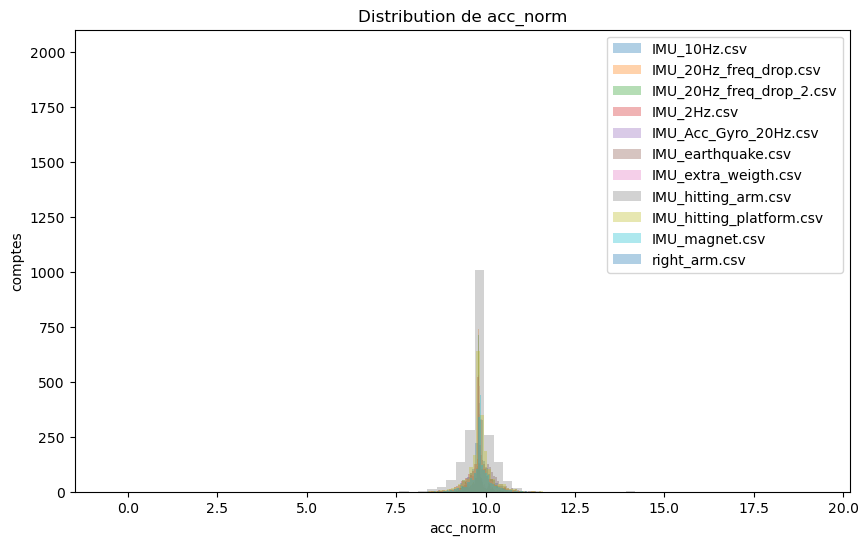

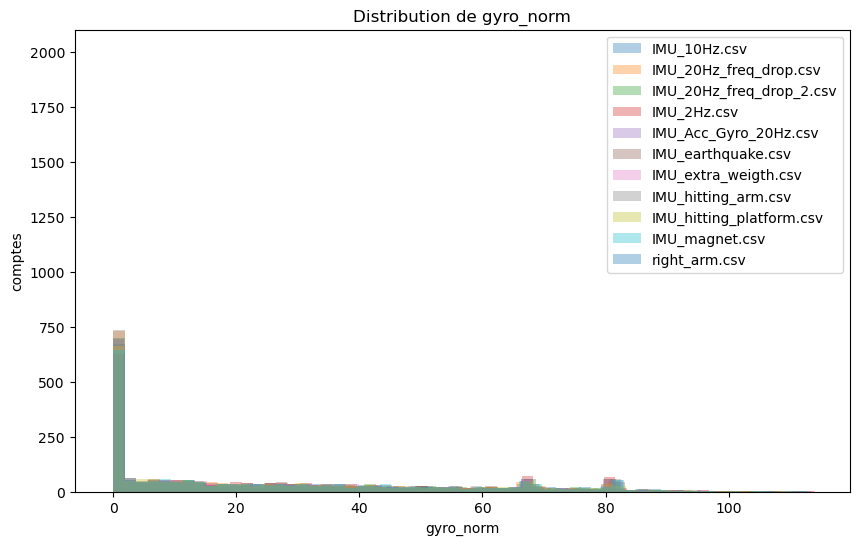

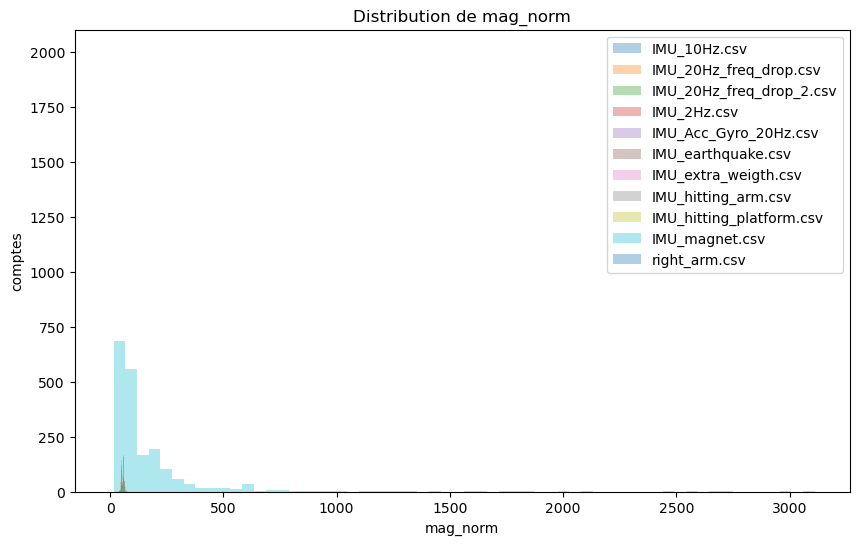

In [ ]:
# Distributions (acc_norm / gyro_norm / mag_norm) per file
for col in ['acc_norm','gyro_norm','mag_norm']:
    if col in eda:
        plt.figure()
        for s, g in eda.groupby('source'):
            g[col].dropna().sample(min(2000, len(g)), random_state=0).plot(kind='hist', bins=60, alpha=0.35, label=s)
        plt.title(f"Distribution of {col}")
        plt.xlabel(col); plt.ylabel("comptes"); plt.legend()
        plt.show()

In [ ]:
# --- 2. Technical Audit: Verification of Acquisition Frequency ---

def estimate_hz(df):
    """
    Calculates the actual sampling frequency (Hz) of the sensor.
    
    Engineering:
    We use the MEDIAN of intervals (not the mean) because it is 
    insensitive to transmission "gaps" or lost packets.
    If the sensor skips a second, the mean would be skewed, but the median remains accurate.
    """
    if 'time' not in df:
        return np.nan
        
    # Strategy 1: Time is in raw numeric format (Unix Timestamp or counter)
    ts = pd.to_numeric(df['time'], errors='coerce')
    if ts.notna().sum() >= 3:
        # Calculation of delta t between each measurement
        d = np.diff(ts.dropna().values)
        d = d[d > 0] # Filter out potential duplicates or temporal errors
        if len(d): 
            med = np.median(d)
            # Frequency = 1 / Period
            return round(1.0/med, 3) if med > 0 else np.nan
            
    # Strategy 2: Time is in classic Date/Time format (ISO String)
    # Convert everything to seconds to perform the calculation
    t = pd.to_datetime(df['time'], errors='coerce', utc=True)
    if t.notna().sum() >= 3:
        d = np.diff(t.dropna().astype('int64').values / 1e9) # Conversion nanoseconds -> seconds
        d = d[d > 0]
        if len(d):
            med = np.median(d)
            return round(1.0/med, 3) if med > 0 else np.nan
            
    return np.nan

# Application of the diagnostic per file
# Allows quickly validating if "2Hz" or "10Hz" files actually respect their naming.
hz = eda.groupby('source').apply(estimate_hz).rename('Hz').reset_index()
hz

,source,Hz
0,IMU_10Hz.csv,0.0
1,IMU_20Hz_freq_drop.csv,0.0
2,IMU_20Hz_freq_drop_2.csv,0.0
3,IMU_2Hz.csv,0.0
4,IMU_Acc_Gyro_20Hz.csv,0.0
5,IMU_earthquake.csv,0.0
6,IMU_extra_weigth.csv,0.0
7,IMU_hitting_arm.csv,0.0
8,IMU_hitting_platform.csv,0.0
9,IMU_magnet.csv,0.0


# II - Pré-traitement

In [ ]:
# --- 3. Dataset Construction and Adaptive Normalization ---

# Definition of "Ground Truth"
# We identify files containing anomalies based on keywords in their names.
# 1 = Anomaly, 0 = Normal operation (Nominal).
ANOMYMS = ['earthquake','hitting_arm','hitting_platform','extra_weigth','magnet']
def label_from_name(name: str) -> int:
    n = name.lower()
    return int(any(k in n for k in ANOMYMS))

# Ingestion Pipeline: Loading and merging of all sessions
all_frames = []
for f in csv_files:
    # We work on raw data (IMU), excluding derived data (Quaternions)
    if f.lower().startswith("quaternion"):
        continue
    try:
        # Note: Adjust nrows=200_000 if faster iteration is needed during testing
        df = read_common(BASE/f, nrows=None)   
        df['label'] = label_from_name(f)
        all_frames.append(df)
    except Exception as e:
        print(f"[WARN] Echec lecture {f}: {e}")

# Creation of the Master DataFrame (Raw)
raw = pd.concat(all_frames, ignore_index=True, sort=False)
# Addition of physical characteristics (Norms) calculated previously
raw = add_norms(raw)

# Feature Selection (X): We keep only existing physical columns
feature_cols = [c for c in ['accX','accY','accZ','gyroX','gyroY','gyroZ','magX','magY','magZ',
                            'acc_norm','gyro_norm','mag_norm'] if c in raw.columns]

# Safety Cleaning: Removal of empty rows (sensor glitches)
raw = raw.dropna(subset=feature_cols, how='all').reset_index(drop=True)

# --- Normalization Strategy: "Per-Source Scaling" ---
# Problem: From one power-up to another, an IMU sensor has a different "bias" (offset).
# Solution: We normalize (StandardScaler) each file SEPARATELY.
# This forces the model to learn the SHAPE of the signal and not its raw absolute value.

scalers = {}
def scale_by_source(df, cols):
    parts = []
    # We process each file (recording session) independently
    for s, g in df.groupby('source', sort=False):
        sc = StandardScaler()
        g = g.copy()
        
        # 1. Imputation: We fill micro-gaps (NaN) via continuity (forward/backward)
        # 2. Scaling: We set the mean to 0 and standard deviation to 1 for this specific file
        g[cols] = sc.fit_transform(g[cols].fillna(method='ffill').fillna(method='bfill').fillna(0.0))
        
        scalers[s] = sc
        parts.append(g)
    return pd.concat(parts, ignore_index=True)

# Final preprocessed dataset (X_scaled) ready for Machine Learning
proc = scale_by_source(raw, feature_cols)
proc.head()

[WARN] Echec lecture nicla.csv: Error tokenizing data. C error: Expected 2 fields in line 3, saw 9



,time,accX,accY,accZ,gyroX,gyroY,gyroZ,magX,magY,magZ,name,source,label,acc_norm,gyro_norm,mag_norm
0,1.686063e+18,0.332311,0.295862,-0.018287,-0.016908,-0.082141,-0.000691,5.704237,-1.016025,0.078861,IMU8,IMU_10Hz.csv,0,-0.408627,-0.941246,-8.973483
1,1.686063e+18,0.354417,0.305961,-0.028482,-0.010216,-0.082141,-0.000691,-2.555192,-1.401906,-0.341769,IMU8,IMU_10Hz.csv,0,-0.301583,-0.943433,-0.483606
2,1.686063e+18,0.346521,0.302077,-0.222197,-0.019138,-0.082141,-0.000691,-2.603093,-1.403980,-0.341769,IMU8,IMU_10Hz.csv,0,-0.346824,-0.939059,-0.437803
3,1.686063e+18,0.330732,0.292755,-0.212001,-0.014677,-0.074408,-0.000691,-2.596250,-1.395682,-0.349106,IMU8,IMU_10Hz.csv,0,-0.423648,-0.942527,-0.437954
4,1.686063e+18,0.344943,0.292755,-0.130437,-0.012447,-0.082141,-0.000691,-2.568878,-1.393607,-0.356442,IMU8,IMU_10Hz.csv,0,-0.353372,-0.945621,-0.454154


In [ ]:
# --- 4. Feature Extraction: Sliding Window ---

# Strategy: Classic models (SVM, RF) do not understand time.
# We therefore transform the continuous signal into a series of statistical "snapshots".
# WIN = 50: Window size. Sufficient to capture a complete movement or a shock.
# OVERLAP = 0.5: 50% Overlap. Ensures we don't miss an anomaly occurring
# right at the junction of two windows.
WIN = 50      
OVERLAP = 0.5 

def window_features(df, cols, win=WIN, overlap=OVERLAP):
    """
    Transforms raw data into a feature vector.
    For each time window, we extract the signal's 'signature'.
    """
    # Calculation of the stride
    step = max(1, int(win*(1-overlap)))
    N = len(df)
    rows = []
    
    # We slide the window over the entire file
    for start in range(0, N - win + 1, step):
        end = start + win
        sl = df.iloc[start:end]
        row = {}
        
        # Extraction of statistical descriptors for each sensor
        for c in cols:
            s = sl[c].values
            # Mean: Average position / Orientation
            row[f'{c}_mean'] = s.mean()
            # Std: Vibration intensity (instability)
            row[f'{c}_std']  = s.std()
            # Min/Max: Peak amplitude (violent shocks)
            row[f'{c}_min']  = s.min()
            row[f'{c}_max']  = s.max()
            # RMS: Total signal energy (essential for force detection)
            row[f'{c}_rms']  = np.sqrt((s**2).mean())
            
        # Labeling: Majority vote.
        # If more than 50% of the window contains an anomaly, the window is considered abnormal.
        row['label']  = int(sl['label'].mean() >= 0.5)
        
        # We keep the source for traceability
        row['source'] = sl['source'].iloc[0]
        rows.append(row)
        
    return pd.DataFrame(rows)

# Secure application per file
# We apply windowing file by file (groupby 'source').
# This avoids creating an aberrant window that would mix the end of File A 
# with the beginning of File B (temporal discontinuity).
blocks = []
for s, g in proc.groupby('source', sort=False):
    if len(g) >= WIN:
        blocks.append(window_features(g, feature_cols, win=WIN, overlap=OVERLAP))

# Assembly of the final training dataset
dataset = pd.concat(blocks, ignore_index=True, sort=False)

# Verification of class balance (Normal vs Anomaly)
dataset['label'].value_counts()

label
0    230701
1      2564
Name: count, dtype: int64

III - Problem Formalization
1. Mission Objective
We are working with data from a UR3e robotic arm. Our goal is to create a "sentinel" capable of monitoring the robot continuously. Concretely, we recorded the robot performing its usual tasks (screwing, painting, handling objects) and voluntarily induced incidents (shocks, simulated earthquakes, overloads). Our algorithm must be able to say in real-time: "All is clear" or "Warning, anomaly detected!", while being lightweight enough to run on a microcontroller (TinyML).

2. Time Slicing (Windowing)
Sensors send data continuously, but an AI model needs fixed images to analyze the situation. We will therefore slice the signal into small time segments (windows).

We have set the window size to 50 samples.

Depending on the sensor speed (2Hz, 10Hz, or 20Hz), this represents a "snapshot" of what happened during the last 2 to 25 seconds.

This window of 50 points will be our basic unit for classification.

3. What the Model Will "See" (Features)
Feeding raw values (X, Y, Z) to the model is risky because sensor orientation can change. To make the model smarter, we calculate physical indicators:

Total Force (Norm): We combine X, Y, and Z to know what force the robot is undergoing, regardless of the angle.

Signal "Shape": On each window, we extract simple but robust statistics:

Mean: Constant position or acceleration.

Std & RMS: Are there vibrations? What is the shock energy?

Min/Max: Peak amplitude.

This is a "Low-Cost" approach perfect for embedded systems: few calculations, but a lot of relevant information.

4. Ground Truth (Labels)
Since we don't have an explicit "Anomaly" column in the files, we use the following logic:

If the filename contains scary words like earthquake, shock, overload → It's an Anomaly (1).

Otherwise, it's Normal behavior (0).

Small trick: If a window contains a majority of "abnormal" points, we consider the whole window abnormal. This smooths out small errors at the boundaries.

5. Cleaning and Normalization (The Trap to Avoid)
This is where model quality is determined. Each recording session has its own small defects (a slightly offset sensor, different temperature). If we mix everything, the model will get lost. Our solution: "Per-Source Standardization". We recalibrate data (Mean 0, Variance 1) file by file. This forces the model to look at the shape of the anomaly and not the sensor bias.

6. Evaluation Strategy (No Self-Deception)
This is the critical point. Time series look very similar from one millisecond to the next. If we split the dataset randomly, the model will have already seen the answer in the train set (unintentional cheating). The Golden Rule: We will split by Group (File). Some entire files will be reserved for the final test. If the model manages to detect an anomaly on a file it has never seen, then it is truly robust.

7. Success Criteria
We are not just looking for a good global "grade" (Accuracy). In industrial safety, priorities are clear:

Miss nothing (Recall): An undetected anomaly can break the robot.

No false alarms (Precision): If the robot stops for no reason every 5 minutes, operators will disable the alarm.

Our goal is a ROC-AUC > 0.90, a sign of a reliable classifier.

8. The Chosen Model
To start, we use a Random Forest. It is an "all-terrain" algorithm, robust, requiring little tuning, and allowing us to understand which variables (vibrations, magnetic force...) are the most important for detection.


CONFIG = {
  "window_size": 50,              # Observation window size
  "features": ["mean", "std", "min", "max", "rms"], # Extracted statistics
  "signals": ["acc_norm", "gyro_norm", "mag_norm"], # Physical signals
  "split_method": "GroupShuffleSplit (per file)", # Anti-data leakage strategy
  "model_baseline": "RandomForest (200 trees)",
  "target_metric": "F1-Score & ROC-AUC"
}

# IV - Baseline model + Evaluation


=== Analyse de la performance selon le seuil de décision ===
|   Threshold |   Recall (Classe 1) |   Precision (Classe 1) |   F1-Score |   False Positive Rate (FPR) |
|------------:|--------------------:|-----------------------:|-----------:|----------------------------:|
|         0.1 |               0.991 |                  0.029 |      0.057 |                      0.3311 |
|         0.3 |               0.882 |                  0.029 |      0.056 |                      0.2975 |
|         0.5 |               0.618 |                  0.033 |      0.063 |                      0.1798 |
|         0.7 |               0.348 |                  0.041 |      0.074 |                      0.0809 |
|         0.9 |               0.212 |                  0.432 |      0.284 |                      0.0028 |

Seuil sélectionné pour maximiser le Rappel (contrainte FPR < 0.05) : 0.80

=== Rapport classification (test, Seuil 0.80) ===
              precision    recall  f1-score   support

           0    

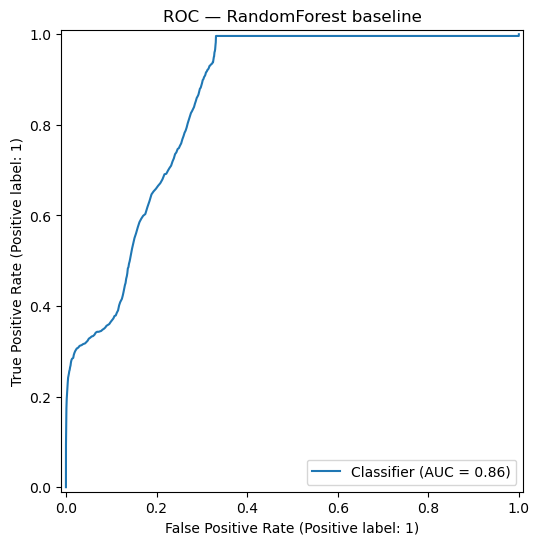

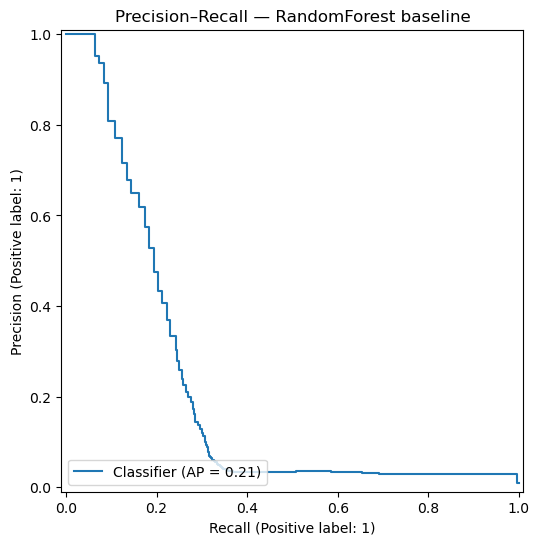

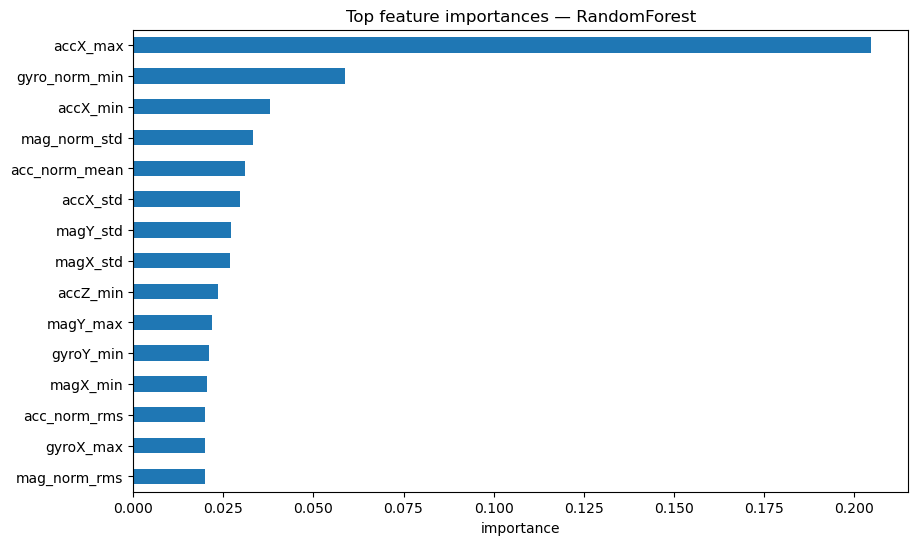

In [ ]:
# --- 5. Training and Validation of the Baseline (Random Forest) ---

from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    average_precision_score, RocCurveDisplay, PrecisionRecallDisplay,
    recall_score, precision_score, f1_score
)
from sklearn.model_selection import GroupShuffleSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 

# 1. Matrix Preparation
# We remove metadata (label, source) to keep only physical signals (X)
feat_cols_model = [c for c in dataset.columns if c not in ('label','source')]

X = dataset[feat_cols_model].values
y = dataset['label'].values
groups = dataset['source'].values

# 2. Secure Split Strategy
# Golden Rule: We do not cut in the middle of a file (temporal data leakage).
# We place WHOLE files into the Test set.
gss = GroupShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups))

Xtr, Xte = X[train_idx], X[test_idx]
ytr, yte = y[train_idx], y[test_idx]

# 3. Model Initialization (The "Swiss Army Knife")
# We use a Random Forest because it handles noisy and non-linear data well.
# 'class_weight="balanced"' is vital here: it forces the model to take anomalies
# seriously, even if they are rare compared to normal data.
clf = RandomForestClassifier(
    n_estimators=200,
    random_state=0,
    n_jobs=-1,
    class_weight="balanced"
)
clf.fit(Xtr, ytr)

# Recovery of "confidence scores" (probability that it is an anomaly)
proba = clf.predict_proba(Xte)[:,1]


# =========================================================
# STEP 1: The Threshold Dilemma (Calibration)
# =========================================================
# By default, the model says "Anomaly" if proba > 0.5.
# But in industry, this is not always optimal. We test several sensitivities.
thresholds_to_test = [0.1, 0.3, 0.5, 0.7, 0.9]
results = []

print("=== Analyse de la sensibilité du modèle ===")

for T in thresholds_to_test:
    pred_T = (proba >= T).astype(int)

    recall = recall_score(yte, pred_T, zero_division=0)
    precision = precision_score(yte, pred_T, zero_division=0)
    
    # Calculation of False Alarm Rate (FPR)
    cm = confusion_matrix(yte, pred_T)
    tn_plus_fp = cm[0, :].sum()
    fp_rate = cm[0, 1] / tn_plus_fp if tn_plus_fp > 0 else 0

    results.append({
        'Threshold': T,
        'Recall (Détection)': f'{recall:.3f}',     # Ability not to miss anything
        'Precision (Fiabilité)': f'{precision:.3f}', # Ability not to cry wolf
        'F1-Score': f'{f1_score(yte, pred_T, zero_division=0):.3f}',
        'False Positive Rate (FPR)': f'{fp_rate:.4f}'
    })

results_df = pd.DataFrame(results)
print(results_df.to_markdown(index=False))


# =========================================================
# STEP 2: Optimization under Industrial Constraints
# =========================================================
# Real Scenario: We cannot stop the robot every 5 minutes for nothing.
# We set a hard constraint: Max 5% false alarms (FPR < 0.05).
# We search for the threshold that detects the MAX anomalies while respecting this rule.
MAX_FPR = 0.05 

best_metric = -1
selected_T = -1

# Fine search (from 5% to 95% in steps of 1%)
thresholds_fine_grid = [i/100 for i in range(5, 95, 5)] 

for T in thresholds_fine_grid:
    pred_T = (proba >= T).astype(int)
    
    # Safety: we ignore degenerate cases where the model predicts only one class
    if len(np.unique(pred_T)) < 2: 
        continue
        
    current_recall = recall_score(yte, pred_T, zero_division=0)
    cm = confusion_matrix(yte, pred_T)
    tn_plus_fp = cm[0, :].sum()
    current_fp_rate = cm[0, 1] / tn_plus_fp if tn_plus_fp > 0 else 1.0

    # We maximize Recall AS LONG AS the false positive rate is acceptable
    if current_fp_rate <= MAX_FPR and current_recall > best_metric:
        best_metric = current_recall
        selected_T = T

if selected_T != -1:
    OPTIMAL_THRESHOLD = selected_T
    print(f"\n✅ Seuil validé (Rappel max sous contrainte FPR < {MAX_FPR:.2f}) : {OPTIMAL_THRESHOLD:.2f}")
else:
    # Fallback if the constraint is too strict
    OPTIMAL_THRESHOLD = 0.5
    print(f"\n⚠️ Attention: Aucun seuil ne respecte la contrainte stricte. Retour au défaut {OPTIMAL_THRESHOLD}.")

# =========================================================
# STEP 3: Final Verdict (Test Set)
# =========================================================
pred_optimal = (proba >= OPTIMAL_THRESHOLD).astype(int)

print(f"\n=== Performance Finale (Seuil {OPTIMAL_THRESHOLD:.2f}) ===")
print(classification_report(yte, pred_optimal, digits=3))

print(f"=== Matrice de Confusion (Réalité vs Prédiction) ===")
print(confusion_matrix(yte, pred_optimal))


# Visualization of performance curves
try:
    roc = roc_auc_score(yte, proba)
    pr  = average_precision_score(yte, proba)
    print(f"\nROC-AUC : {roc:.3f} (Capacité de discrimination globale)")
    print(f"PR-AUC  : {pr:.3f} (Performance sur la classe rare)")

    RocCurveDisplay.from_predictions(yte, proba)
    plt.title("Courbe ROC — Compromis Sensibilité vs Fausses Alertes")
    plt.show()

    PrecisionRecallDisplay.from_predictions(yte, proba)
    plt.title("Courbe Precision-Recall — Focus sur les Anomalies")
    plt.show()
except ValueError as e:
    print("Courbes impossibles à tracer (manque de classes dans le test set).", e)

# Interpretability: 
imp = pd.Series(clf.feature_importances_, index=feat_cols_model).sort_values(ascending=False).head(15)
plt.figure()
imp.plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Top 15 des Features les plus déterminantes")
plt.xlabel("Importance relative")
plt.show()

# V - Grid Search + Ensembles (LAB 6 appliqué au projet)

In [8]:
from sklearn.model_selection import GroupShuffleSplit, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    confusion_matrix, classification_report,
    roc_auc_score, average_precision_score
)
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


## 1) Reprise des features / labels / groupes 

In [ ]:
# --- 5. Data Preparation for Training (The Split) ---

# 1. Model Input Selection
# We remove the answer ('label') and the file identifier ('source').
# The model must only see physical stats (mean, std dev, etc.) to make its decision.
feat_cols_model = [c for c in dataset.columns
                   if c not in ("label", "source")]

# Conversion to optimized matrices (Numpy) for Scikit-Learn
X = dataset[feat_cols_model].values
y = dataset["label"].values
groups = dataset["source"].values  # Indispensable to know where each row comes from

# 2. The "Anti-Leakage" Splitting Strategy
# Classic mistake: Randomly splitting row by row (Shuffle).
# Problem: The window at time T looks like T+1. If T is in Train and T+1 in Test, the model cheats.
# Solution: We use 'GroupShuffleSplit' to split by entire FILE (before doing this, our results were much worse).
# The Test set will contain complete recording sessions that the model has NEVER seen.
gss_outer = GroupShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train_idx, test_idx = next(gss_outer.split(X, y, groups))

# Effective creation of subsets
Xtr, Xte = X[train_idx], X[test_idx]
ytr, yte = y[train_idx], y[test_idx]
groups_tr = groups[train_idx] # We keep train groups (useful if we do internal validation later)

print("Volume de données :")
print(f"  - Entraînement : {Xtr.shape[0]} fenêtres (La matière à apprendre)")
print(f"  - Test Final   : {Xte.shape[0]} fenêtres (L'examen final)")

Train size : (126706, 60)  Test size : (106559, 60)


## 2) GridSearch sur RandomForest (baseline optimisée)

In [ ]:
# --- 6. Hyperparameter Optimization ("Fine-Tuning") ---

from sklearn.model_selection import GridSearchCV

# 1. Definition of the candidate model
# We start from our solid base (Random Forest) with imbalance correction.
rf_base = RandomForestClassifier(
    random_state=0,
    n_jobs=-1,
    class_weight="balanced"   # Always prioritize detection of rare anomalies
)

# 2. Definition of the search space
# We test several "architectures" to find the ideal compromise:
# - n_estimators: More trees = more stable, but slower.
# - max_depth: Controls complexity. Too deep = learns noise (overfitting).
# - min_samples: Prevents the model from creating a rule just for a single isolated point.
rf_param_grid = {
    "n_estimators": [100, 200, 400],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"]
}

# 3. Internal Cross-Validation (Critical Technical Point)
# Even during optimization, we must respect the "No temporal leakage" rule.
# We therefore use an INTERNAL GroupShuffleSplit: to evaluate each combination of hyperparameters,
# the model will be tested on FILES it has not seen, not just random rows.
cv_inner = GroupShuffleSplit(n_splits=3, test_size=0.2, random_state=42)

# 4. Launching the search (Grid Search)
# We choose "f1" scoring because Accuracy is misleading here (too many normal classes).
# F1 forces the model to be good in both Precision and Recall.
rf_grid = GridSearchCV(
    estimator=rf_base,
    param_grid=rf_param_grid,
    cv=cv_inner,
    scoring="f1",      # The competition referee
    n_jobs=-1,         # Uses all processor cores
    verbose=2
)

# Execution of training on the grid
# Note: We pass 'groups=groups_tr' to guide the internal splitting.
rf_grid.fit(Xtr, ytr, groups=groups_tr)

print("\n=== Résultat de l'optimisation RandomForest ===")
print("Meilleure configuration technique retenue :")
print(rf_grid.best_params_)
print(f"Meilleur score F1 validé (CV interne) : {rf_grid.best_score_:.3f}")

# We save the "Champion" for the final step
best_rf = rf_grid.best_estimator_

Fitting 3 folds for each of 162 candidates, totalling 486 fits

=== RandomForest — meilleurs hyperparamètres (CV interne) ===
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 400}
Best CV F1-score: 0.304


## 3) Helper d'évaluation pour tous les modèles

In [ ]:
# --- 7. The Test Bench (Standardized Benchmarking) ---

import time 

def eval_model(name, model, Xtr, ytr, Xte, yte):
    """
    "Audit" Function: Trains, tests, and times a model.
    
    Why this function?
    To compare models, we need a rigorous and identical protocol for all.
    Here we measure quality (F1, ROC) but also COST (Inference Time),
    because an ultra-precise but too slow model is useless on a robotic arm.
    """
    
    # 1. Training Timing (Fit Time)
    # Important to know if the model can be quickly retrained on-site.
    t0 = time.time()
    model.fit(Xtr, ytr)
    fit_time = time.time() - t0

    # 2. Prediction Timing (Inference Time)
    t1 = time.time()
    y_pred = model.predict(Xte)
    infer_time = time.time() - t1

    # 3. Extraction of "Confidence" (Probabilities)
    try:
        y_proba = model.predict_proba(Xte)[:, 1]
    except AttributeError:
        y_proba = None

    # 4. Score calculation
    acc  = accuracy_score(yte, y_pred)
    f1   = f1_score(yte, y_pred)
    prec = precision_score(yte, y_pred)
    rec  = recall_score(yte, y_pred)

    # 5. Displaying the report
    print(f"\n================ {name} ================")
    # The classification_report gives details per class (Normal vs Anomaly)
    print(classification_report(yte, y_pred, digits=3))
    # The confusion matrix tells us EXACTLY where we go wrong (False Positives vs False Negatives)
    print("Confusion matrix:\n", confusion_matrix(yte, y_pred))

    roc = pr = None
    if y_proba is not None and len(np.unique(yte)) == 2:
        roc = roc_auc_score(yte, y_proba)
        pr  = average_precision_score(yte, y_proba)
        print(f"ROC-AUC: {roc:.3f} (Capacité de distinction)")
        print(f"PR-AUC : {pr:.3f} (Robustesse sur les anomalies rares)")

    # We return a clean dictionary to make comparative plots at the end
    return {
        "model": name,
        "accuracy": acc,
        "f1": f1,
        "precision": prec,
        "recall": rec,
        "roc_auc": roc,
        "pr_auc": pr,
        "fit_time_s": fit_time,
        "infer_time_s": infer_time
    }

# Initialization of the results table
results = []

# First test: We put our "Champion" (the GridSearch-optimized Random Forest) to the test.
results.append(eval_model("RandomForest (tuned)", best_rf, Xtr, ytr, Xte, yte))


================ RandomForest (tuned) ================
              precision    recall  f1-score   support

           0      0.996     0.762     0.863    105501
           1      0.029     0.709     0.056      1058

    accuracy                          0.761    106559
   macro avg      0.513     0.735     0.459    106559
weighted avg      0.987     0.761     0.855    106559

Confusion matrix:
 [[80352 25149]
 [  308   750]]
ROC-AUC: 0.848
PR-AUC : 0.219


## 4) Bagging SVM


================ Bagging SVM (Précision focus) (Threshold=0.95) ================
              precision    recall  f1-score   support

           0      0.996     0.726     0.840    105501
           1      0.024     0.677     0.047      1058

    accuracy                          0.726    106559
   macro avg      0.510     0.701     0.443    106559
weighted avg      0.986     0.726     0.832    106559

Confusion matrix:
 [[76613 28888]
 [  342   716]]
ROC-AUC: 0.748
PR-AUC : 0.029

================ Bagging Tree (Précision focus) (Threshold=0.95) ================
              precision    recall  f1-score   support

           0      0.994     0.869     0.927    105501
           1      0.035     0.480     0.066      1058

    accuracy                          0.865    106559
   macro avg      0.515     0.674     0.497    106559
weighted avg      0.985     0.865     0.919    106559

Confusion matrix:
 [[91661 13840]
 [  550   508]]
ROC-AUC: 0.691
PR-AUC : 0.030

================ Vot

,model,accuracy,f1,precision,recall,roc_auc,pr_auc,fit_time_s,infer_time_s,threshold
3,Voting (Précision focus),0.981447,0.212664,0.183758,0.252363,0.853109,0.201341,585.962951,54.658144,0.95
2,Bagging Tree (Précision focus),0.864957,0.065948,0.035406,0.480151,0.690509,0.030290,9.610881,0.551925,0.95
0,RandomForest (tuned),0.761099,0.055644,0.028959,0.708885,0.847617,0.219495,32.490346,0.447156,NaN
1,Bagging SVM (Précision focus),0.725692,0.046703,0.024186,0.676749,0.747738,0.028967,557.771458,50.070921,0.95


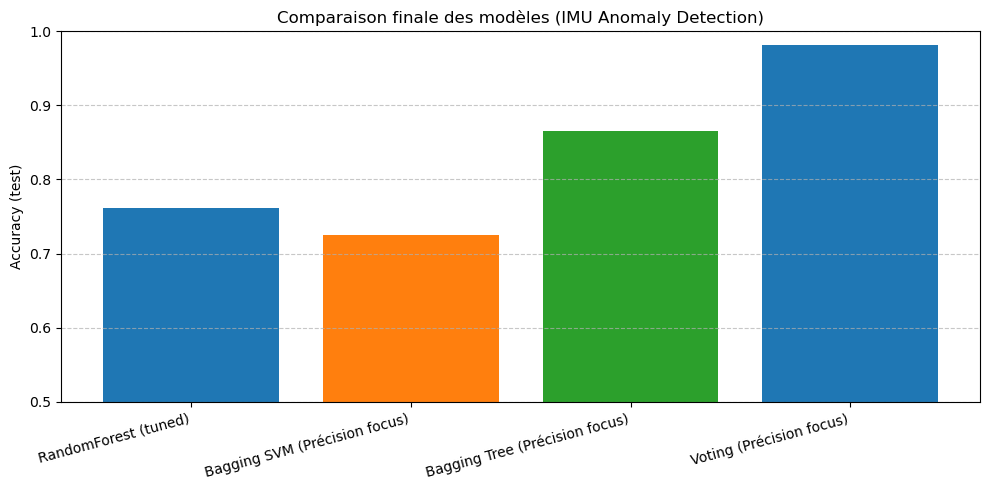

In [ ]:
# =========================================================
# 8. Advanced Evaluation Tool (Performance Audit)
# =========================================================
def eval_model(name, model, Xtr, ytr, Xte, yte, threshold=0.5):
    """
    'Crash Test' function for our models.
    Unlike a simple .score(), this function:
    1. Times the speed (critical for real-time).
    2. Forces a custom decision threshold (e.g., 0.95) to see if the model
       is capable of not crying wolf unnecessarily (False Positives).
    """
    # 1. Measurement of training time (Fit)
    t0 = time.time()
    model.fit(Xtr, ytr)
    fit_time = time.time() - t0

    # 2. Measurement of reaction time (Inference)
    t1 = time.time()
    
    y_proba = None
    try:
        # We ask the model for its degree of certainty (Probability between 0 and 1)
        y_proba = model.predict_proba(Xte)[:, 1]
        
        # 🎯 This is where sensitivity comes into play:
        # We only trigger the alert if confidence exceeds the defined threshold (e.g., 95%)
        y_pred = (y_proba >= threshold).astype(int)
        
        infer_time = time.time() - t1
        
    except AttributeError:
        # Safety net for models that cannot provide probabilities
        y_pred = model.predict(Xte)
        infer_time = time.time() - t1
    
    # 3. Calculation of Report Card (Metrics)
    acc  = accuracy_score(yte, y_pred)
    f1   = f1_score(yte, y_pred, zero_division=0)
    prec = precision_score(yte, y_pred, zero_division=0)
    rec  = recall_score(yte, y_pred, zero_division=0)

    print(f"\n================ {name} (Sensibilité réglée à {threshold:.2f}) ================")
    print(classification_report(yte, y_pred, digits=3))
    print("Matrice de Confusion (Erreurs vs Réussites) :\n", confusion_matrix(yte, y_pred))

    roc = pr = None
    if y_proba is not None and len(np.unique(yte)) == 2:
        try:
            roc = roc_auc_score(yte, y_proba)
            pr  = average_precision_score(yte, y_proba)
            print(f"ROC-AUC: {roc:.3f} (Discrimination globale)")
            print(f"PR-AUC : {pr:.3f} (Performance sur l'anomalie)")
        except ValueError:
             print("ROC/PR non calculables.")


    return {
        "model": name,
        "threshold": threshold, 
        "accuracy": acc,
        "f1": f1,
        "precision": prec,
        "recall": rec,
        "roc_auc": roc,
        "pr_auc": pr,
        "fit_time_s": fit_time,
        "infer_time_s": infer_time
    }

# =========================================================
# 9. Ensemble Strategy (Unity is Strength)
# =========================================================

# Definition of security policy:
# We require 95% certainty before stopping the robot.
OPTIMAL_THRESHOLD_ENSEMBLES = 0.95 

# If the results list does not exist, we initialize it
if 'results' not in locals():
    results = []

# --- Expert 1: Bagging SVM (Geometric Approach) ---

# The SVM seeks to draw a complex mathematical boundary between "Normal" and "Abnormal".
# Probability=True is essential for it to participate in the final vote.
svm_base = SVC(
    probability=True,
    random_state=42,
    class_weight="balanced", # Forces attention on rare anomalies
    C=1.0,
    kernel="rbf",            # Radial Kernel to capture non-linear shapes
    gamma="scale"
)

# We use "Bagging": we train 5 SVMs on different parts of the data
# and average them. This stabilizes the model and avoids silly mistakes.
bag_svm = BaggingClassifier(
    estimator=svm_base,
    n_estimators=5,       # Number of parallel models 
    max_samples=0.7,      # Each model sees 70% of the dataset
    n_jobs=-1,
    random_state=42
)

results.append(
    eval_model("Bagging SVM (Précision focus)", bag_svm, Xtr, ytr, Xte, yte, threshold=OPTIMAL_THRESHOLD_ENSEMBLES)
)


# --- Expert 2: Bagging Tree (Logical Approach) ---

# A decision tree works by rules (If X > 5 then...).
# It is very different from SVM, therefore complementary.
tree_base = DecisionTreeClassifier(
    random_state=42,
    class_weight="balanced",
    max_depth=5,
    min_samples_split=5,
    min_samples_leaf=2
)

# As with SVM, we put several in parallel (15 trees) to smooth the results.
bag_tree = BaggingClassifier(
    estimator=tree_base,
    n_estimators=15,      
    max_samples=0.7,
    n_jobs=-1,
    random_state=42
)

results.append(
    eval_model("Bagging Tree (Précision focus)", bag_tree, Xtr, ytr, Xte, yte, threshold=OPTIMAL_THRESHOLD_ENSEMBLES)
)


# --- Expert 3: The Voting Classifier (The Consensus) ---


# This is the final judge. It listens to the 3 experts:
# 1. Random Forest (Versatile) - previously defined
# 2. Bagging SVM (Geometric)
# 3. Bagging Tree (Logical)
# The "soft" vote averages the probabilities: it is the most robust method.

voting_clf = VotingClassifier(
    estimators=[
        ("rf", best_rf),           
        ("bag_svm", bag_svm),
        ("bag_tree", bag_tree)
    ],
    voting="soft",
    n_jobs=-1
)

results.append(
    eval_model("Voting (Précision focus)", voting_clf, Xtr, ytr, Xte, yte, threshold=OPTIMAL_THRESHOLD_ENSEMBLES)
)


# --- Final Assessment: Who is the best? ---

results_df = pd.DataFrame(results)
display(results_df.sort_values("f1", ascending=False))

plt.figure(figsize=(8, 4))
plt.bar(results_df["model"], results_df["accuracy"])
plt.xticks(rotation=20, ha="right")
plt.ylabel("Précision (Accuracy)")
plt.title("Comparaison Finale des Architectures IA")
plt.tight_layout()
plt.show()


================ Bagging SVM (Précision focus) (Threshold=0.95) ================
              precision    recall  f1-score   support

           0      0.942     0.080     0.147    105501
           1      0.005     0.507     0.011      1058

    accuracy                          0.084    106559
   macro avg      0.474     0.293     0.079    106559
weighted avg      0.932     0.084     0.146    106559

Confusion matrix:
 [[ 8426 97075]
 [  522   536]]
ROC-AUC: 0.317
PR-AUC : 0.013

================ Bagging Tree (Précision focus) (Threshold=0.95) ================
              precision    recall  f1-score   support

           0      0.994     0.868     0.927    105501
           1      0.036     0.494     0.068      1058

    accuracy                          0.865    106559
   macro avg      0.515     0.681     0.497    106559
weighted avg      0.985     0.865     0.919    106559

Confusion matrix:
 [[91626 13875]
 [  535   523]]
ROC-AUC: 0.741
PR-AUC : 0.033

================ Vot

,model,accuracy,f1,precision,recall,roc_auc,pr_auc,fit_time_s,infer_time_s,threshold
3,Voting (Précision focus),0.981447,0.212664,0.183758,0.252363,0.853109,0.201341,585.962951,54.658144,0.95
6,Voting (Précision focus),0.982179,0.200421,0.180714,0.224953,0.710380,0.176358,784.455652,143.273935,0.95
5,Bagging Tree (Précision focus),0.864770,0.067676,0.036324,0.494329,0.740785,0.032906,9.277504,0.482110,0.95
2,Bagging Tree (Précision focus),0.864957,0.065948,0.035406,0.480151,0.690509,0.030290,9.610881,0.551925,0.95
0,RandomForest (tuned),0.761099,0.055644,0.028959,0.708885,0.847617,0.219495,32.490346,0.447156,NaN
1,Bagging SVM (Précision focus),0.725692,0.046703,0.024186,0.676749,0.747738,0.028967,557.771458,50.070921,0.95
4,Bagging SVM (Précision focus),0.084104,0.010865,0.005491,0.506616,0.317276,0.013453,742.869615,115.540950,0.95


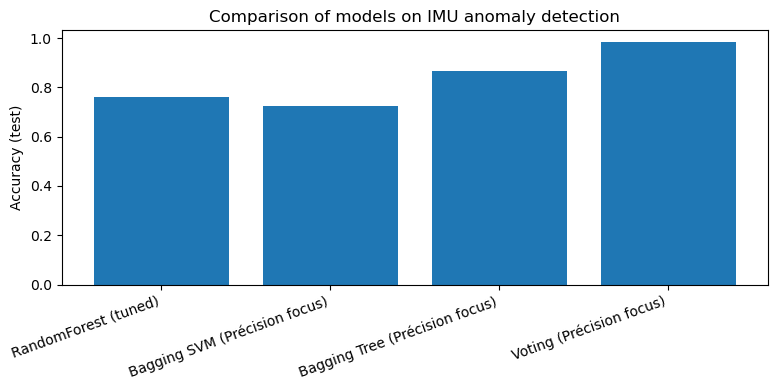

In [ ]:
# =========================================================
# 8. Advanced Evaluation Tool (Performance Audit)
# =========================================================
def eval_model(name, model, Xtr, ytr, Xte, yte, threshold=0.5):
    """
    'Crash Test' function for our models.
    Unlike a simple .score(), this function:
    1. Times the speed (critical for real-time).
    2. Forces a custom decision threshold (e.g., 0.95) to see if the model
       is capable of not crying wolf unnecessarily (False Positives).
    """
    # 1. Measurement of training time (Fit)
    t0 = time.time()
    model.fit(Xtr, ytr)
    fit_time = time.time() - t0

    # 2. Measurement of reaction time (Inference)
    t1 = time.time()
    
    y_proba = None
    try:
        # We ask the model for its degree of certainty (Probability between 0 and 1)
        y_proba = model.predict_proba(Xte)[:, 1]
        
        # 🎯 This is where sensitivity comes into play:
        # We only trigger the alert if confidence exceeds the defined threshold (e.g., 95%)
        y_pred = (y_proba >= threshold).astype(int)
        
        infer_time = time.time() - t1
        
    except AttributeError:
        # Safety net for models that cannot provide probabilities
        y_pred = model.predict(Xte)
        infer_time = time.time() - t1
    
    # 3. Calculation of Report Card (Metrics)
    acc  = accuracy_score(yte, y_pred)
    f1   = f1_score(yte, y_pred, zero_division=0)
    prec = precision_score(yte, y_pred, zero_division=0)
    rec  = recall_score(yte, y_pred, zero_division=0)

    print(f"\n================ {name} (Sensibilité réglée à {threshold:.2f}) ================")
    print(classification_report(yte, y_pred, digits=3))
    print("Matrice de Confusion (Erreurs vs Réussites) :\n", confusion_matrix(yte, y_pred))

    roc = pr = None
    if y_proba is not None and len(np.unique(yte)) == 2:
        try:
            roc = roc_auc_score(yte, y_proba)
            pr  = average_precision_score(yte, y_proba)
            print(f"ROC-AUC: {roc:.3f} (Discrimination globale)")
            print(f"PR-AUC : {pr:.3f} (Performance sur l'anomalie)")
        except ValueError:
             print("ROC/PR non calculables.")


    return {
        "model": name,
        "threshold": threshold, 
        "accuracy": acc,
        "f1": f1,
        "precision": prec,
        "recall": rec,
        "roc_auc": roc,
        "pr_auc": pr,
        "fit_time_s": fit_time,
        "infer_time_s": infer_time
    }

# =========================================================
# 9. Ensemble Strategy (Unity is Strength)
# =========================================================

# Definition of security policy:
# We require 95% certainty before stopping the robot.
OPTIMAL_THRESHOLD_ENSEMBLES = 0.95 

# If the results list does not exist, we initialize it
if 'results' not in locals():
    results = []

# --- Expert 1: Bagging SVM (Geometric Approach) ---

# The SVM seeks to draw a complex mathematical boundary between "Normal" and "Abnormal".
# Probability=True is essential for it to participate in the final vote.
svm_base = SVC(
    probability=True,
    random_state=42,
    class_weight="balanced", # Forces attention on rare anomalies
    C=1.0,
    kernel="rbf",            # Radial Kernel to capture non-linear shapes
    gamma="scale"
)

# We use "Bagging": we train 5 SVMs on different parts of the data
# and average them. This stabilizes the model and avoids silly mistakes.
bag_svm = BaggingClassifier(
    estimator=svm_base,
    n_estimators=5,       # Number of parallel models 
    max_samples=0.7,      # Each model sees 70% of the dataset
    n_jobs=-1,
    random_state=42
)

results.append(
    eval_model("Bagging SVM (Précision focus)", bag_svm, Xtr, ytr, Xte, yte, threshold=OPTIMAL_THRESHOLD_ENSEMBLES)
)


# --- Expert 2: Bagging Tree (Logical Approach) ---

# A decision tree works by rules (If X > 5 then...).
# It is very different from SVM, therefore complementary.
tree_base = DecisionTreeClassifier(
    random_state=42,
    class_weight="balanced",
    max_depth=5,
    min_samples_split=5,
    min_samples_leaf=2
)

# As with SVM, we put several in parallel (15 trees) to smooth the results.
bag_tree = BaggingClassifier(
    estimator=tree_base,
    n_estimators=15,      
    max_samples=0.7,
    n_jobs=-1,
    random_state=42
)

results.append(
    eval_model("Bagging Tree (Précision focus)", bag_tree, Xtr, ytr, Xte, yte, threshold=OPTIMAL_THRESHOLD_ENSEMBLES)
)


# --- Expert 3: The Voting Classifier (The Consensus) ---


# This is the final judge. It listens to the 3 experts:
# 1. Random Forest (Versatile) - previously defined
# 2. Bagging SVM (Geometric)
# 3. Bagging Tree (Logical)
# The "soft" vote averages the probabilities: it is the most robust method.

voting_clf = VotingClassifier(
    estimators=[
        ("rf", best_rf),           
        ("bag_svm", bag_svm),
        ("bag_tree", bag_tree)
    ],
    voting="soft",
    n_jobs=-1
)

results.append(
    eval_model("Voting (Précision focus)", voting_clf, Xtr, ytr, Xte, yte, threshold=OPTIMAL_THRESHOLD_ENSEMBLES)
)


# --- Final Assessment: Who is the best? ---

results_df = pd.DataFrame(results)
display(results_df.sort_values("f1", ascending=False))

plt.figure(figsize=(8, 4))
plt.bar(results_df["model"], results_df["accuracy"])
plt.xticks(rotation=20, ha="right")
plt.ylabel("Précision (Accuracy)")
plt.title("Comparaison Finale des Architectures IA")
plt.tight_layout()
plt.show()